# Probabilité de hausse du Fed Funds rate à partir des Fed Funds Futures

Ce notebook étudie dans quelle mesure les **Fed Funds Futures** dans une première partie puis les données macroéconomiques dans une seconde partie, contiennent de l’information sur les
**hausses futures du taux des Fed Funds (FEDFUNDS)**.

Ce notebook est divisé en deux parties:


**Une première partie où on se base que sur les Fed Funds Futures pour prédire la hausse ou baisse du Effective Fed Funds Rate.**


**Une seconde partie où on enrichit le modèle avec des données macroéconomique afin d'améliorer l'accuracy.**

L’idée est de construire, pour chaque mois \(t\), une variable cible binaire
indiquant si le taux monte au mois suivant 

À partir des contrats futures, nous calculons :
- le **taux implicite** (100 – prix du future) ;
- une **volatilité mensuelle** (écart entre taux implicite haut et bas) ;
- le **spread** entre taux implicite et taux effectif FEDFUNDS, ainsi que plusieurs
  **retards (lags)** de ces variables.

Ces variables servent de **features** dans un modèle de **régression logistique** avec
standardisation et pondération des classes (les hausses de taux étant rares).

Chacune des parties est organisé en plusieurs étapes :

Pour la première partie ci-dessous nous avons:


1. **Préparation des données**
   - Chargement et mise en cohérence des séries FEDFUNDS et Fed Funds Futures.
   - Construction du spread, de la volatilité mensuelle et de leurs lags.

2. **Définition de la cible et du modèle**
   - Création de la variable cible de hausse de taux au pas de temps suivant.
   - Estimation d’un modèle logistique reliant la probabilité de hausse aux
     features (spread, volatilité et lags).

3. **Évaluation « out-of-sample » (walk-forward)**
   - Mise en place d’un schéma récursif : à chaque date, le modèle est ré-entraîné
     uniquement sur les données passées, puis utilisé pour **prévoir la probabilité de
     hausse** pour la période suivante.
   - Analyse des probabilités prédites, de la matrice de confusion et de l’impact de la volatilité.

4. **Modèle final « in-sample »**
   - Ré-estimation du modèle sur **toute l’histoire disponible** afin d’obtenir une
     spécification finale.
   - Comparaison des performances in-sample et out-of-sample pour discuter du
     pouvoir prédictif réel des Fed Funds Futures.



L’objectif n’est pas de construire une stratégie de trading, mais de montrer
comment exploiter l’information contenue dans les Fed Funds Futures pour
**modéliser et quantifier la probabilité d’une hausse du taux directeur**.


### Data importation

In [1]:
import pandas as pd

In [2]:
EFFR = pd.read_csv("data/FEDFUNDS.csv", sep=",", )
FFF = pd.read_csv("data/Federal_Fund_Future.csv", sep=";")

# Convertir les colonnes en type date
EFFR['observation_date'] = pd.to_datetime(EFFR['observation_date'])  
FFF['Date'] = pd.to_datetime(FFF['Date'])    # Remplace 'date' par le nom de la colonne appropriée

print(EFFR.head())
print(EFFR.info())
print(FFF.head())
print(FFF.info())


  observation_date  FEDFUNDS
0       2003-01-01      1.24
1       2003-02-01      1.26
2       2003-03-01      1.25
3       2003-04-01      1.26
4       2003-05-01      1.26
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  273 non-null    datetime64[ns]
 1   FEDFUNDS          273 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.4 KB
None
        Date   Price     Open     High      Low     Vol. Change %
0 2025-10-01  95.910  95.9225  95.9225  95.9075    1.44M    0.14%
1 2025-09-01  95.775  95.7675  95.7950  95.7650    2.46M    0.11%
2 2025-08-01  95.670  95.6750  95.6825  95.6675    1.28M    0.00%
3 2025-07-01  95.670  95.6700  95.6725  95.6675    1.01M    0.00%
4 2025-06-01  95.670  95.6725  95.6750  95.6700  696.84K    0.00%
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [3]:
FFF = FFF.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], errors='ignore')
FFF['implicite_fund_rate'] = 100 - FFF['Price']

print(EFFR.dtypes)
print(FFF.dtypes)




observation_date    datetime64[ns]
FEDFUNDS                   float64
dtype: object
Date                   datetime64[ns]
Price                         float64
implicite_fund_rate           float64
dtype: object


In [4]:
display(EFFR)
display(FFF)

,observation_date,FEDFUNDS
0,2003-01-01,1.24
1,2003-02-01,1.26
2,2003-03-01,1.25
3,2003-04-01,1.26
4,2003-05-01,1.26
...,...,...
268,2025-05-01,4.33
269,2025-06-01,4.33
270,2025-07-01,4.33
271,2025-08-01,4.33


,Date,Price,implicite_fund_rate
0,2025-10-01,95.910,4.090
1,2025-09-01,95.775,4.225
2,2025-08-01,95.670,4.330
3,2025-07-01,95.670,4.330
4,2025-06-01,95.670,4.330
...,...,...,...
269,2003-05-01,98.750,1.250
270,2003-04-01,98.750,1.250
271,2003-03-01,98.750,1.250
272,2003-02-01,98.740,1.260


### Comparaison de l'évolution du EFFR VS Implicite Fund rate

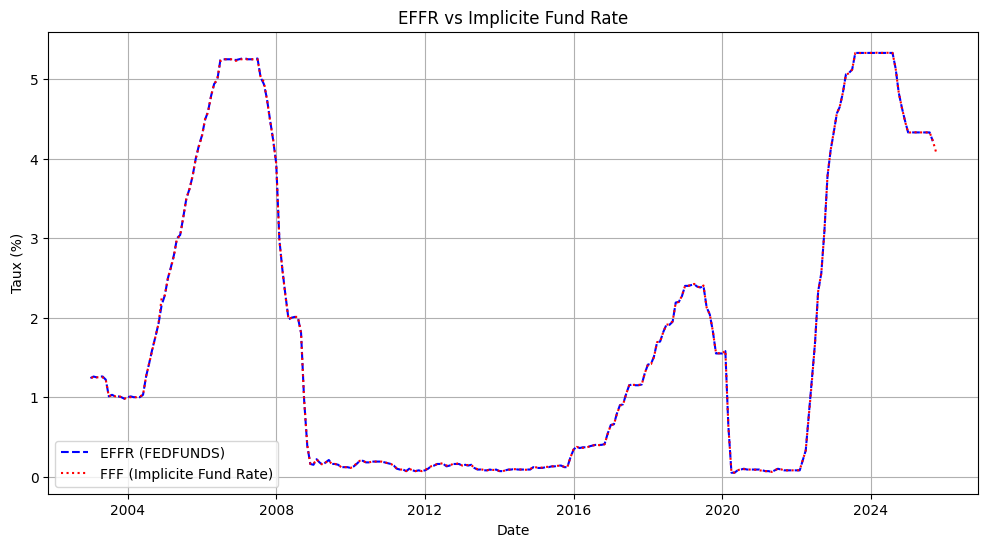

In [5]:
# tracer les series temporelles des deux datasets (implicite_fund_rate et FEDFUNDS ) superposer sur la meme figure``
import matplotlib.pyplot as plt

# ...existing code...

plt.figure(figsize=(12, 6))

# Tracer la première série avec une couleur et un style de ligne
plt.plot(EFFR['observation_date'], EFFR['FEDFUNDS'], label='EFFR (FEDFUNDS)', color='blue', linestyle='--')

# Tracer la deuxième série avec une couleur différente et un style de ligne
plt.plot(FFF['Date'], FFF['implicite_fund_rate'], label='FFF (Implicite Fund Rate)', color='red', linestyle=':')

plt.xlabel('Date')
plt.ylabel('Taux (%)')
plt.title('EFFR vs Implicite Fund Rate')
plt.legend()
plt.grid()
plt.show()

# ...existing code...



,Date,implicite_fund_rate,observation_date,FEDFUNDS
0,2025-09-01,4.225,2025-09-01,4.22
1,2025-08-01,4.330,2025-08-01,4.33
2,2025-07-01,4.330,2025-07-01,4.33
3,2025-06-01,4.330,2025-06-01,4.33
4,2025-05-01,4.330,2025-05-01,4.33
...,...,...,...,...
268,2003-05-01,1.250,2003-05-01,1.26
269,2003-04-01,1.250,2003-04-01,1.26
270,2003-03-01,1.250,2003-03-01,1.25
271,2003-02-01,1.260,2003-02-01,1.26


,Date,implicite_fund_rate,observation_date,FEDFUNDS,difference
0,2025-09-01,4.225,2025-09-01,4.22,5.000000e-03
1,2025-08-01,4.330,2025-08-01,4.33,-1.776357e-15
2,2025-07-01,4.330,2025-07-01,4.33,-1.776357e-15
3,2025-06-01,4.330,2025-06-01,4.33,-1.776357e-15
4,2025-05-01,4.330,2025-05-01,4.33,-1.776357e-15
...,...,...,...,...,...
268,2003-05-01,1.250,2003-05-01,1.26,-1.000000e-02
269,2003-04-01,1.250,2003-04-01,1.26,-1.000000e-02
270,2003-03-01,1.250,2003-03-01,1.25,0.000000e+00
271,2003-02-01,1.260,2003-02-01,1.26,5.107026e-15


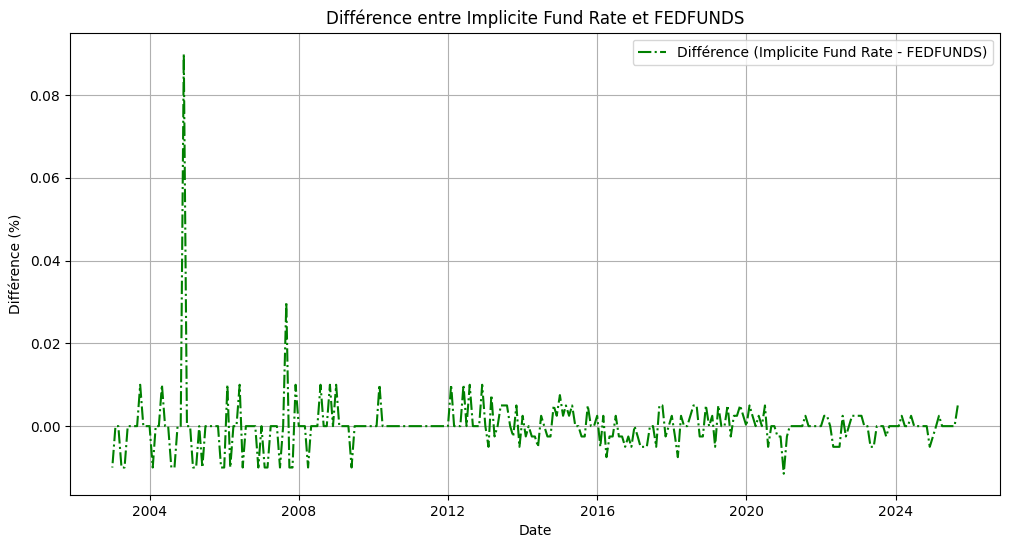

In [ ]:

# Fusionner les DataFrames sur les dates
merged_df = pd.merge(FFF[['Date', 'implicite_fund_rate']], EFFR[['observation_date', 'FEDFUNDS']], 
                      left_on='Date', right_on='observation_date', how='inner')
display(merged_df)

# Calculer la différence
merged_df['difference'] = merged_df['implicite_fund_rate'] - merged_df['FEDFUNDS']

display(merged_df)

# Tracer la série de la différence sur une nouvelle figure
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['difference'], label='Différence (Implicite Fund Rate - FEDFUNDS)', color='green', linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Différence (%)')
plt.title('Différence entre Implicite Fund Rate et FEDFUNDS')
plt.legend()
plt.grid()
plt.show()

# ...existing code...

Ce graphique représente l’écart entre le taux implicite des Federal Funds Futures et le taux effectif FEDFUNDS. On observe que, la plupart du temps, la différence reste très faible (quelques points de base autour de zéro), ce qui indique que les futures intègrent correctement le niveau anticipé du taux directeur. Quelques épisodes se distinguent toutefois par des pics plus marqués, notamment autour de 2004-2006 et, dans une moindre mesure, à l’approche de 2008 puis lors de la période 2019-2020 : ces écarts traduisent des phases d’incertitude accrue ou de réajustement rapide des anticipations de marché face aux décisions de la Fed.

Mean Squared Error: 0.016281401653338867
R^2 Score: 0.9957044101616688
Coefficient implicite_fund_rate_lag_1: 1.5662224593548841
Coefficient implicite_fund_rate_lag_2: -0.6688736963331853
Coefficient implicite_fund_rate_lag_3: 0.23751145967879475
Coefficient implicite_fund_rate_lag_4: -0.23555888066023783
Coefficient implicite_fund_rate_lag_5: 0.30439729429533924
Coefficient implicite_fund_rate_lag_6: -0.21448065315539896
Intercept: 0.009907013672302067


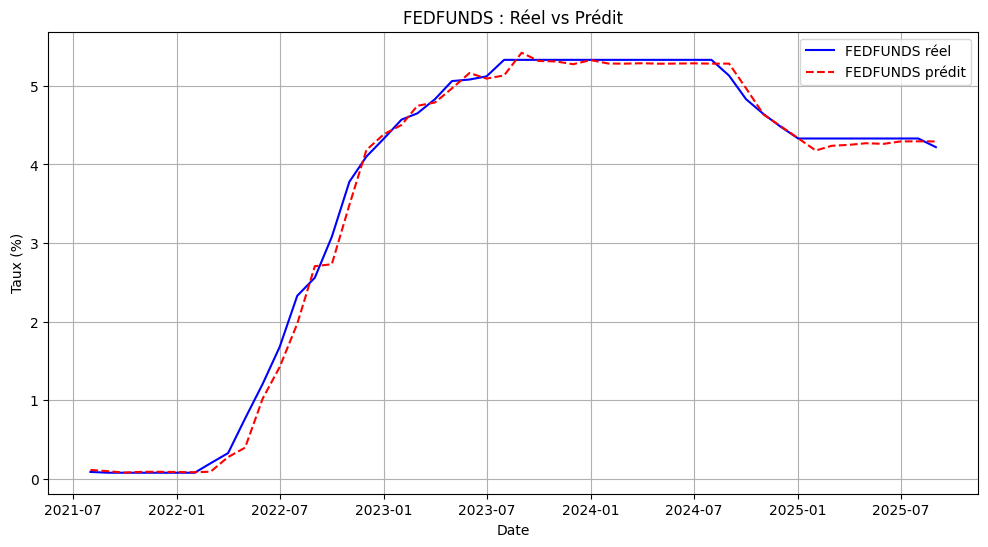

In [10]:
# Créer les features décalées (lag features)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
n_lags = 6  # nombre de mois précédents à utiliser
merged_df = merged_df.sort_values('Date')  # Trier par date

# Créer les colonnes décalées
for i in range(1, n_lags + 1):
    merged_df[f'implicite_fund_rate_lag_{i}'] = merged_df['implicite_fund_rate'].shift(i)

# Supprimer les lignes avec des valeurs manquantes (début de série)
merged_df = merged_df.dropna()

# Séparer les caractéristiques (X) et la cible (y)
lag_columns = [f'implicite_fund_rate_lag_{i}' for i in range(1, n_lags + 1 )]
X = merged_df[lag_columns]
y = merged_df['FEDFUNDS']

# Diviser les données en ensembles d'entraînement et de test
# On garde les dernières 20% des données pour le test (plus réaliste temporellement)
split_idx = int(len(merged_df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédire et évaluer
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Afficher les coefficients pour chaque lag
for lag, coef in zip(lag_columns, model.coef_):
    print(f'Coefficient {lag}: {coef}')
print(f'Intercept: {model.intercept_}')

# Visualiser les prédictions
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'].iloc[split_idx:], y_test, label='FEDFUNDS réel', color='blue')
plt.plot(merged_df['Date'].iloc[split_idx:], y_pred, label='FEDFUNDS prédit', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Taux (%)')
plt.title('FEDFUNDS : Réel vs Prédit')
plt.legend()
plt.grid(True)
plt.show()

Nous utilisons ici une régression linéaire sur 6 retards du **taux implicite issu des Fed Funds futures** pour expliquer le taux effectif des Fed Funds (`FEDFUNDS`). Les données sont triées chronologiquement et l’on conserve les **20 % dernières dates comme échantillon de test**, ce qui est cohérent avec une problématique de prévision de série temporelle.

Visuellement, la courbe prédite (pointillés rouges) suit de très près la courbe réelle (bleu) sur la période de test :

- le modèle reproduit correctement **le niveau** du taux directeur ;
- il capture bien la **dynamique globale**, en particulier :
  - la phase de hausse rapide entre 2022 et 2023 ;
  - le plateau autour de 5 %.

On observe seulement de légers écarts lors des changements de régime (accélération ou début de baisse), ce qui est classique pour un modèle linéaire simple basé uniquement sur des lags.

Les métriques (MSE et \(R^2\)) confirment cette impression visuelle : la qualité d’ajustement est satisfaisante compte tenu du fait que l’on n’utilise **que l’information contenue dans l’historique des taux implicites**, sans autres variables macroéconomiques.

Ce modèle fournit donc une première base raisonnable pour relier les prix de futures aux taux réalisés, mais il pourrait être amélioré en :

- testant un nombre de retards différent ;
- autorisant des effets non linéaires (par exemple modèles régularisés ou arbres) ;
- ajoutant des variables explicatives supplémentaires (inflation, chômage, indicateurs de marché, etc.).



Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        31
           1       0.47      0.39      0.42        18

    accuracy                           0.61        49
   macro avg       0.57      0.57      0.57        49
weighted avg       0.60      0.61      0.60        49


Confusion Matrix:
[[23  8]
 [11  7]]


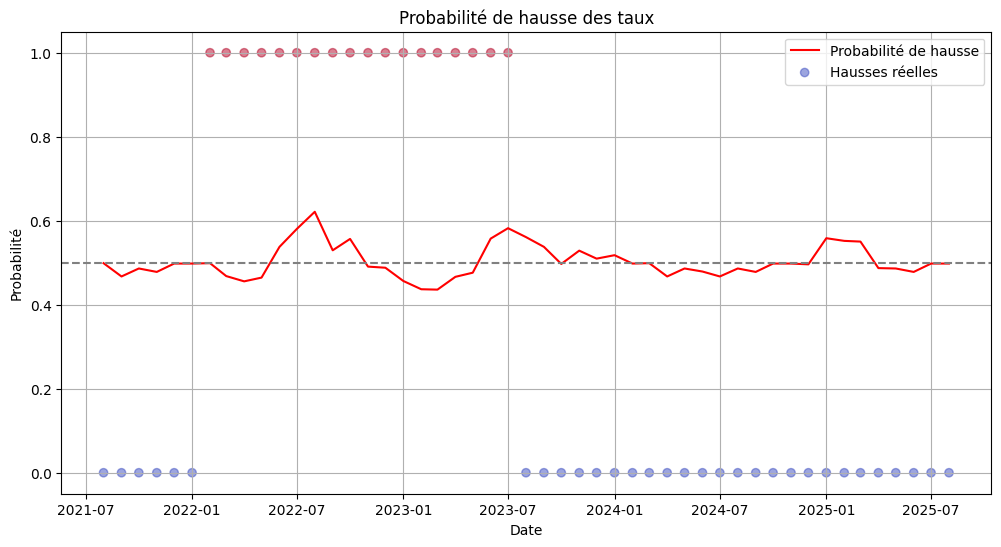


Importance des features:
        feature  importance
1  spread_lag_1    0.245054
3  spread_lag_3    0.158693
2  spread_lag_2    0.093342
0        spread    0.007268


In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Calculer la variation du taux FEDFUNDS
merged_df['FEDFUNDS_change'] = merged_df['FEDFUNDS'].diff().shift(-1)  # variation au prochain pas de temps
merged_df['target'] = (merged_df['FEDFUNDS_change'] > 0).astype(int)  # 1 si hausse, 0 sinon

# Calculer le spread
merged_df['spread'] = merged_df['implicite_fund_rate'] - merged_df['FEDFUNDS']

# Créer features avec spread et lags
n_lags = 3
for i in range(1, n_lags + 1):
    merged_df[f'spread_lag_{i}'] = merged_df['spread'].shift(i)

# Nettoyer données
merged_df = merged_df.dropna()

# Features
feature_columns = ['spread'] + [f'spread_lag_{i}' for i in range(1, n_lags + 1)]
X = merged_df[feature_columns]
y = merged_df['target']

# Split temporel
split_idx = int(len(merged_df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Standardiser
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle
clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

# Prédictions
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Évaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualiser probabilités prédites
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'].iloc[split_idx:], y_proba, label='Probabilité de hausse', color='red')
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.scatter(merged_df['Date'].iloc[split_idx:], y_test, 
           c=y_test, cmap='coolwarm', label='Hausses réelles', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Probabilité')
plt.title('Probabilité de hausse des taux')
plt.legend()
plt.grid(True)
plt.show()

# Importance des features
importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(clf.coef_[0])
})
importances = importances.sort_values('importance', ascending=False)
print("\nImportance des features:")
print(importances)

Ce bloc de code met en place un modèle de **classification** pour prédire si le taux des **FEDFUNDS va augmenter au prochain mois**. On commence par construire une cible binaire (`target`) qui vaut 1 en cas de hausse future du taux, puis on calcule le **spread** entre le taux implicite des Fed Funds futures et le taux effectif (`spread = implicite_fund_rate - FEDFUNDS`). Ce spread, ainsi que ses trois retards mensuels, servent de **variables explicatives**.

Les données sont ensuite **découpées temporellement** (80 % pour l’entraînement, 20 % pour le test), les features sont **standardisées**, puis une **régression logistique** (avec pondération des classes) est entraînée pour estimer la probabilité de hausse. Le modèle est évalué via le **classification report** et la **matrice de confusion**, la probabilité de hausse est visualisée dans le temps, et l’on examine enfin l’**importance des différentes features** à partir des coefficients du modèle.


Le graphique illustre, sur la période de test, les probabilités de hausse de taux prédites par la régression logistique (courbe rouge) ainsi que les hausses effectivement observées (points en haut pour 1, en bas pour 0). Le modèle, estimé uniquement à partir du spread et de ses décalages, atteint une accuracy d’environ 61 % : il identifie correctement la majorité des périodes sans hausse, mais ne détecte qu’une partie des hausses (rappel ≈ 39 % pour la classe 1). On voit néanmoins que, lors de la phase de resserrement monétaire 2022-2023, les probabilités prédites sont nettement plus élevées et s’alignent globalement sur le cycle de hausses, ce qui montre que le spread contient bien une information prédictive, même si le pouvoir explicatif reste limité pour un modèle aussi parcimonieux.

In [12]:
display(merged_df)

,Date,implicite_fund_rate,observation_date,FEDFUNDS,difference,implicite_fund_rate_lag_1,implicite_fund_rate_lag_2,implicite_fund_rate_lag_3,implicite_fund_rate_lag_4,implicite_fund_rate_lag_5,implicite_fund_rate_lag_6,FEDFUNDS_change,target,spread,spread_lag_1,spread_lag_2,spread_lag_3
245,2005-04-01,2.78,2005-04-01,2.79,-1.000000e-02,2.6200,2.5000,2.2800,2.2500,1.9300,1.7600,0.21,1,-1.000000e-02,-1.000000e-02,0.000000e+00,1.332268e-15
244,2005-05-01,3.00,2005-05-01,3.00,0.000000e+00,2.7800,2.6200,2.5000,2.2800,2.2500,1.9300,0.04,1,0.000000e+00,-1.000000e-02,-1.000000e-02,0.000000e+00
243,2005-06-01,3.03,2005-06-01,3.04,-1.000000e-02,3.0000,2.7800,2.6200,2.5000,2.2800,2.2500,0.22,1,-1.000000e-02,0.000000e+00,-1.000000e-02,-1.000000e-02
242,2005-07-01,3.26,2005-07-01,3.26,5.329071e-15,3.0300,3.0000,2.7800,2.6200,2.5000,2.2800,0.24,1,5.329071e-15,-1.000000e-02,0.000000e+00,-1.000000e-02
241,2005-08-01,3.50,2005-08-01,3.50,0.000000e+00,3.2600,3.0300,3.0000,2.7800,2.6200,2.5000,0.12,1,0.000000e+00,5.329071e-15,-1.000000e-02,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2025-04-01,4.33,2025-04-01,4.33,-1.776357e-15,4.3325,4.3300,4.3275,4.4750,4.6400,4.8300,0.00,0,-1.776357e-15,2.500000e-03,-1.776357e-15,-2.500000e-03
4,2025-05-01,4.33,2025-05-01,4.33,-1.776357e-15,4.3300,4.3325,4.3300,4.3275,4.4750,4.6400,0.00,0,-1.776357e-15,-1.776357e-15,2.500000e-03,-1.776357e-15
3,2025-06-01,4.33,2025-06-01,4.33,-1.776357e-15,4.3300,4.3300,4.3325,4.3300,4.3275,4.4750,0.00,0,-1.776357e-15,-1.776357e-15,-1.776357e-15,2.500000e-03
2,2025-07-01,4.33,2025-07-01,4.33,-1.776357e-15,4.3300,4.3300,4.3300,4.3325,4.3300,4.3275,0.00,0,-1.776357e-15,-1.776357e-15,-1.776357e-15,-1.776357e-15


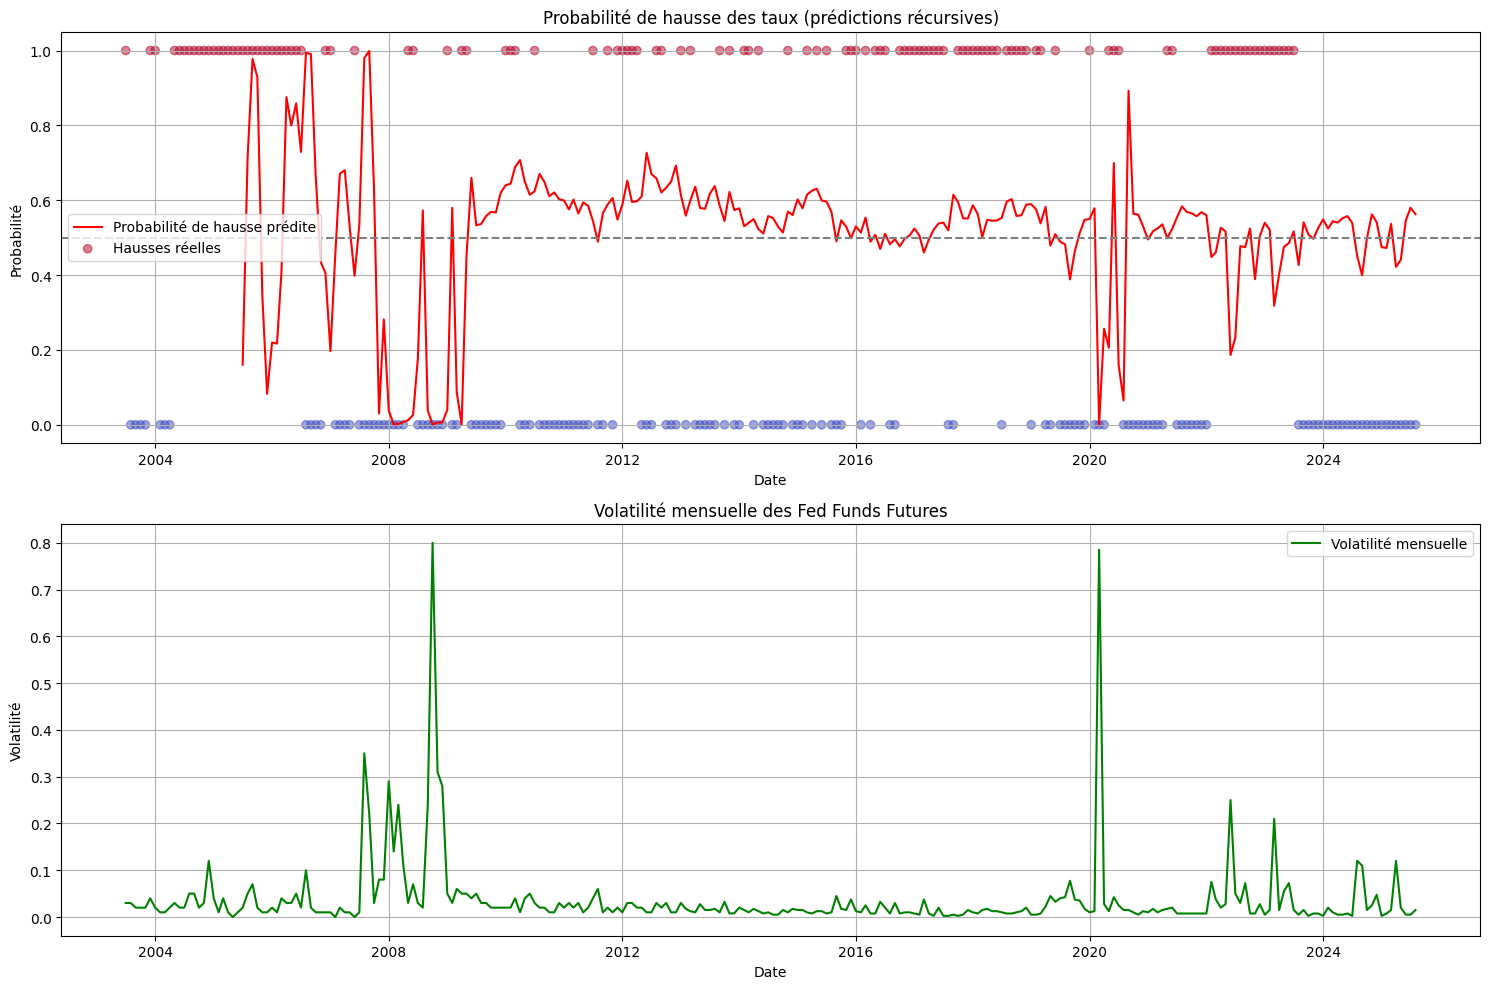


Rapport de classification sur toute la période:
              precision    recall  f1-score   support

           0       0.52      0.27      0.35       139
           1       0.40      0.67      0.50       103

    accuracy                           0.44       242
   macro avg       0.46      0.47      0.43       242
weighted avg       0.47      0.44      0.42       242



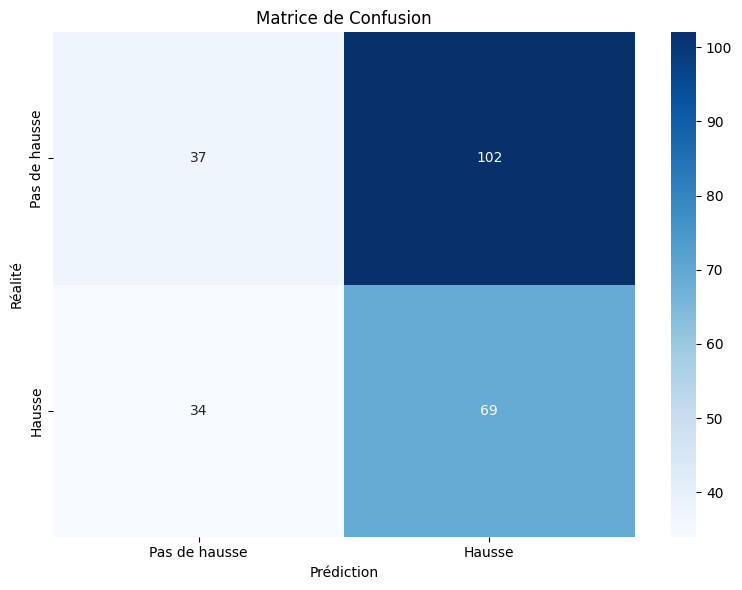


Importance des features:
               feature  importance
1   monthly_volatility    0.285989
12    volatility_lag_5    0.210089
8     volatility_lag_1    0.174923
0               spread    0.103792
11    volatility_lag_4    0.088718
10    volatility_lag_3    0.079866
5         spread_lag_4    0.067781
3         spread_lag_2    0.065129
7         spread_lag_6    0.035787
4         spread_lag_3    0.026426
9     volatility_lag_2    0.025393
13    volatility_lag_6    0.023533
6         spread_lag_5    0.022822
2         spread_lag_1    0.001700


In [15]:
# 1. Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 2. Chargement des données
EFFR = pd.read_csv("data/FEDFUNDS.csv", sep=",")
FFF = pd.read_csv("data/Federal_Fund_Future.csv", sep=";")

# Conversion des dates
EFFR['observation_date'] = pd.to_datetime(EFFR['observation_date'])
FFF['Date'] = pd.to_datetime(FFF['Date'])

# 3. Préparation des features
# Calcul des taux implicites
FFF['implicite_fund_rate'] = 100 - FFF['Price']
FFF['implicite_fund_rate_high'] = 100 - FFF['Low']
FFF['implicite_fund_rate_low'] = 100 - FFF['High']
FFF['monthly_volatility'] = FFF['implicite_fund_rate_high'] - FFF['implicite_fund_rate_low']

# 4. Fusion des données
merged_df = pd.merge(
    FFF[['Date', 'implicite_fund_rate', 'monthly_volatility']], 
    EFFR[['observation_date', 'FEDFUNDS']], 
    left_on='Date', right_on='observation_date', 
    how='inner'
)

# 5. Création des features
merged_df = merged_df.sort_values('Date')
merged_df['spread'] = merged_df['implicite_fund_rate'] - merged_df['FEDFUNDS']
merged_df['FEDFUNDS_change'] = merged_df['FEDFUNDS'].diff().shift(-1)
merged_df['target'] = (merged_df['FEDFUNDS_change'] > 0).astype(int)

# Création des lags
n_lags = 6
for i in range(1, n_lags + 1):
    merged_df[f'spread_lag_{i}'] = merged_df['spread'].shift(i)
    merged_df[f'volatility_lag_{i}'] = merged_df['monthly_volatility'].shift(i)

# Nettoyage des données
merged_df = merged_df.dropna()

# 6. Définition des features
feature_columns = ['spread', 'monthly_volatility'] + \
                 [f'spread_lag_{i}' for i in range(1, n_lags + 1)] + \
                 [f'volatility_lag_{i}' for i in range(1, n_lags + 1)]

# 7. Fonction pour créer les features
def create_features(data, current_date):
    mask = data['Date'] <= current_date
    X = data.loc[mask, feature_columns].copy()
    y = data.loc[mask, 'target'].copy()
    return X, y

# 8. Prédictions récursives
dates = merged_df['Date'].sort_values().unique()
all_predictions = []
all_probabilities = []

initial_train_size = 24
scaler = StandardScaler()
clf = LogisticRegression(random_state=42, class_weight='balanced')

for i in range(initial_train_size, len(dates)):
    current_date = dates[i-1]
    prediction_date = dates[i]
    
    X_train, y_train = create_features(merged_df, current_date)
    X_train_scaled = scaler.fit_transform(X_train)
    clf.fit(X_train_scaled, y_train)
    
    X_test = merged_df.loc[merged_df['Date'] == prediction_date, feature_columns]
    X_test_scaled = scaler.transform(X_test)
    
    pred = clf.predict(X_test_scaled)
    prob = clf.predict_proba(X_test_scaled)[:, 1]
    
    all_predictions.append(pred[0])
    all_probabilities.append(prob[0])

# 9. Ajout des prédictions au DataFrame
prediction_dates = dates[initial_train_size:]
merged_df['predicted_prob'] = np.nan
merged_df['predicted_target'] = np.nan
merged_df.loc[merged_df['Date'].isin(prediction_dates), 'predicted_prob'] = all_probabilities
merged_df.loc[merged_df['Date'].isin(prediction_dates), 'predicted_target'] = all_predictions

# 10. Visualisations
plt.figure(figsize=(15, 10))

# Probabilités de hausse
plt.subplot(2, 1, 1)
plt.plot(merged_df['Date'], merged_df['predicted_prob'], 
         label='Probabilité de hausse prédite', color='red')
plt.scatter(merged_df['Date'], merged_df['target'], 
           c=merged_df['target'], cmap='coolwarm', 
           label='Hausses réelles', alpha=0.5)
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Probabilité')
plt.title('Probabilité de hausse des taux (prédictions récursives)')
plt.legend()
plt.grid(True)

# Volatilité
plt.subplot(2, 1, 2)
plt.plot(merged_df['Date'], merged_df['monthly_volatility'], 
         label='Volatilité mensuelle', color='green')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.title('Volatilité mensuelle des Fed Funds Futures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Évaluation
y_true = merged_df.loc[merged_df['Date'].isin(prediction_dates), 'target']
y_pred = merged_df.loc[merged_df['Date'].isin(prediction_dates), 'predicted_target']

print("\nRapport de classification sur toute la période:")
print(classification_report(y_true, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pas de hausse', 'Hausse'],
            yticklabels=['Pas de hausse', 'Hausse'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.tight_layout()
plt.show()

# 12. Importance des features
importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(clf.coef_[0])
})
print("\nImportance des features:")
print(importances.sort_values('importance', ascending=False))

Contrairement au premier modèle, qui entraînait une régression logistique une seule fois sur un découpage fixe (80 % des données pour l’apprentissage, 20 % pour le test) en utilisant uniquement le spread et quelques lags, le modèle présenté ici adopte une approche plus réaliste de **prédictions récursives**. 

À chaque date, le modèle est ré-entraîné uniquement sur l’historique disponible jusqu’à la période précédente, puis il prédit la probabilité de hausse pour la période suivante. De plus, les variables explicatives sont enrichies : en plus du spread, on intègre désormais la **volatilité mensuelle des Fed Funds Futures** ainsi que plusieurs retards du spread et de cette volatilité. On obtient ainsi une évaluation véritablement « out-of-sample » et une meilleure prise en compte de la dynamique de marché.


### Détails du modèle

Le graphique illustre le fonctionnement d’un **modèle de régression logistique** estimé en **prédiction récursive** :

1. **Variable à prédire (« target »)**  
   - Comme précédemment,à chaque date \(t\), on définit  
une variable binaire qui vaut 1 si le taux des Fed Funds **augmente au mois suivant**, et 0 sinon.

2. **Variables explicatives (features)**  
   Le modèle ne regarde que l’information disponible au temps \(t\) :
   - le **spread** entre le taux implicite des Fed Funds Futures et le taux effectif FEDFUNDS ;
   - la **volatilité mensuelle** du contrat futures (écart entre taux implicite haut et bas) ;
   - plusieurs **retards (lags)** de ces deux grandeurs.  
   L’idée est que :
   - un spread positif et persistant signale que le marché **anticipe des hausses** ;
   - une forte volatilité traduit une **incertitude ou re-pricing** liés aux annonces de politique monétaire.

3. **Schéma récursif (walk-forward)**  
   - On choisit une fenêtre d’**apprentissage initiale** (les 24 premiers mois).  
   - Pour chaque nouvelle date :
     1. on **ré-entraîne** le modèle uniquement sur les données disponibles jusqu’à cette date ;
     2. on prédit la probabilité de hausse pour le **mois suivant**.  
   - Les probabilités rouges sur le graphique sont donc de **vraies prévisions hors échantillon**, faites « comme si » on était à l’époque considérée.

4. **Interprétation des graphiques et de la matrice de confusion**  
   - Quand la courbe rouge est proche de 1, le modèle estime qu’une hausse est très probable ; proche de 0, il n’en anticipe pas.  
   - La matrice de confusion montre :
     - un nombre non négligeable de hausses correctement détectées (69 vrais positifs) ;
     - mais aussi beaucoup de **fausses alertes** (102 cas où le modèle prévoit une hausse qui n’a pas lieu).  
   - Le modèle est donc **agressif** : il préfère lever des signaux de hausse quitte à avoir une précision globale modeste, ce qui peut être acceptable si l’objectif est avant tout de **ne pas rater les épisodes de resserrement monétaire**.

En résumé, ce modèle simple montre que le spread et la volatilité des Fed Funds Futures contiennent effectivement de l’information sur les futures hausses de taux, mais qu’ils ne suffisent pas à produire des prévisions très fiables sans générer de nombreux faux signaux.



Classification report (sur les lignes historiques connues utilisées pour entraînement final) :
              precision    recall  f1-score   support

           0       0.60      0.38      0.46       147
           1       0.47      0.68      0.56       120

    accuracy                           0.52       267
   macro avg       0.53      0.53      0.51       267
weighted avg       0.54      0.52      0.51       267


Confusion matrix:
 [[56 91]
 [38 82]]


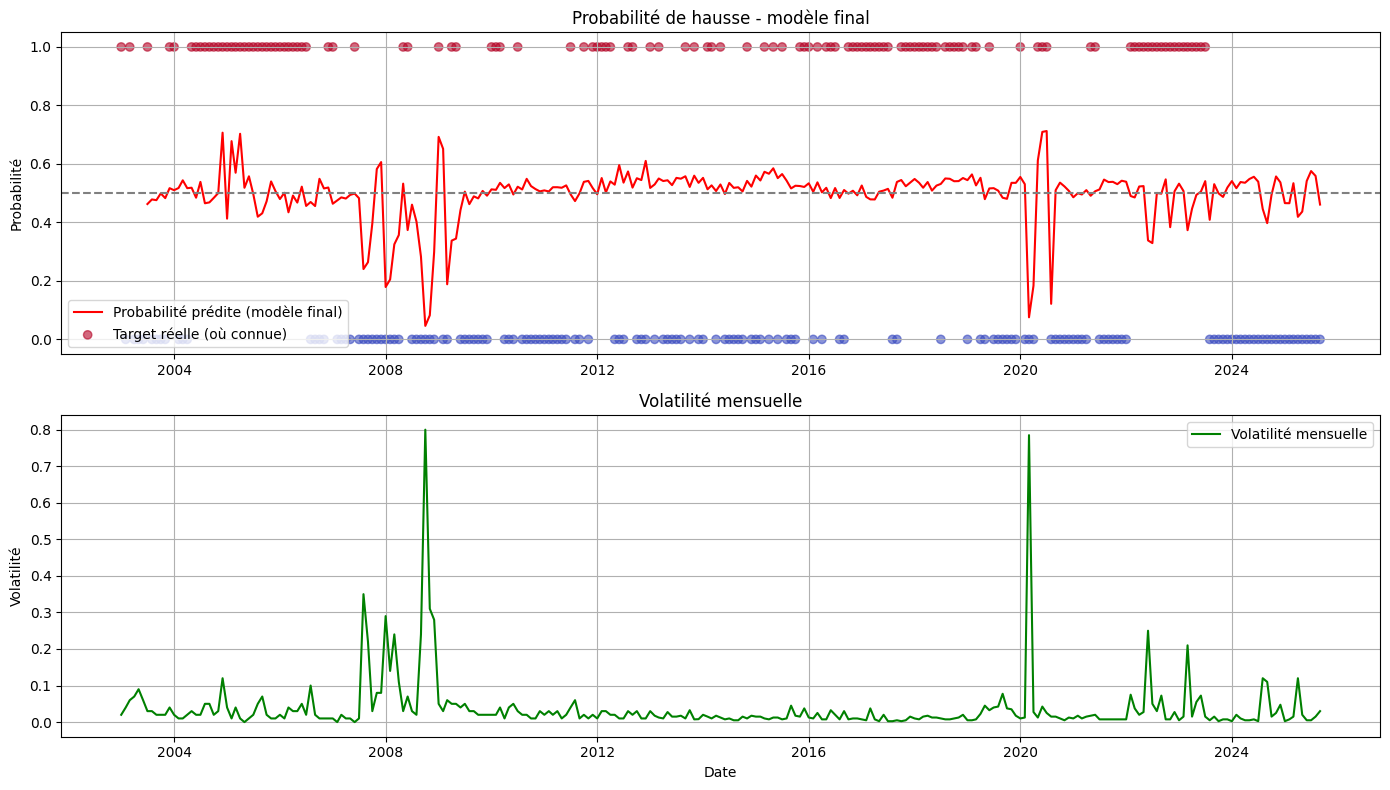

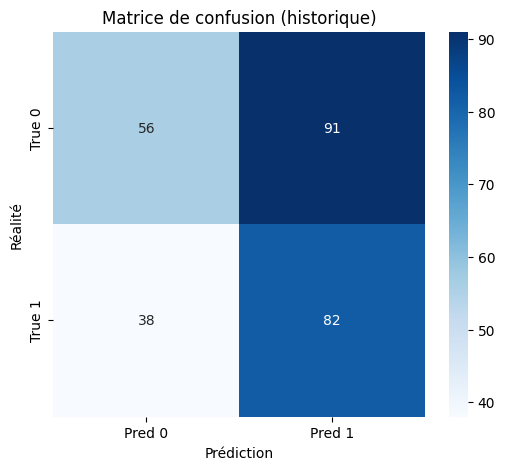


Importance (abs coef) :
               feature  importance
1   monthly_volatility    0.285598
12    volatility_lag_5    0.219248
8     volatility_lag_1    0.169500
0               spread    0.098995
10    volatility_lag_3    0.085105
11    volatility_lag_4    0.079781
5         spread_lag_4    0.067879
3         spread_lag_2    0.062893
7         spread_lag_6    0.032731
9     volatility_lag_2    0.030110
4         spread_lag_3    0.025986
6         spread_lag_5    0.020097
13    volatility_lag_6    0.014699
2         spread_lag_1    0.001446


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1) Chargement
EFFR = pd.read_csv("data/FEDFUNDS.csv", sep=",")
FFF = pd.read_csv("data/Federal_Fund_Future.csv", sep=";")

# 2) Dates
EFFR['observation_date'] = pd.to_datetime(EFFR['observation_date'])
FFF['Date'] = pd.to_datetime(FFF['Date'])

# 3) Features de base
# taux implicite
FFF['implicite_fund_rate'] = 100 - FFF['Price']

# volatilité mensuelle si High/Low disponibles
if {'High', 'Low'}.issubset(FFF.columns):
    FFF['implicite_fund_rate_high'] = 100 - FFF['Low']
    FFF['implicite_fund_rate_low'] = 100 - FFF['High']
    FFF['monthly_volatility'] = FFF['implicite_fund_rate_high'] - FFF['implicite_fund_rate_low']
else:
    FFF['monthly_volatility'] = 0.0

# 4) Fusion
merged_df = pd.merge(
    FFF[['Date', 'implicite_fund_rate', 'monthly_volatility']],
    EFFR[['observation_date', 'FEDFUNDS']],
    left_on='Date', right_on='observation_date', how='inner'
)
merged_df = merged_df.sort_values('Date').reset_index(drop=True)

# 5) Target (haussse prochaine période) — target will be NaN for the last row
merged_df['FEDFUNDS_next'] = merged_df['FEDFUNDS'].shift(-1)
merged_df['FEDFUNDS_change_next'] = merged_df['FEDFUNDS_next'] - merged_df['FEDFUNDS']
merged_df['target'] = (merged_df['FEDFUNDS_change_next'] > 0).astype(float)  # float so NaN remains for last

# 6) Lags (features)
n_lags = 6
merged_df['spread'] = merged_df['implicite_fund_rate'] - merged_df['FEDFUNDS']
for i in range(1, n_lags + 1):
    merged_df[f'spread_lag_{i}'] = merged_df['spread'].shift(i)
    merged_df[f'volatility_lag_{i}'] = merged_df['monthly_volatility'].shift(i)

# 7) Définir colonnes features
feature_columns = ['spread', 'monthly_volatility'] + \
                  [f'spread_lag_{i}' for i in range(1, n_lags + 1)] + \
                  [f'volatility_lag_{i}' for i in range(1, n_lags + 1)]

# 8) Préparer jeu d'entraînement final : utiliser toutes les lignes où target est connue
train_mask = merged_df['target'].notna() & merged_df[feature_columns].notna().all(axis=1)
X_train_final = merged_df.loc[train_mask, feature_columns].copy()
y_train_final = merged_df.loc[train_mask, 'target'].astype(int).copy()

# Sanity check
if X_train_final.empty:
    raise RuntimeError("Aucun enregistrement complet pour l'entraînement final (vérifier l'ordre / lags).")

# 9) Entraîner modèle final sur toute l'histoire disponible (sans la dernière ligne dont target est inconnue)
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train_final)

clf_final = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
clf_final.fit(X_train_scaled, y_train_final)

# 10) Prédictions sur toutes les dates pour lesquelles les features sont connues
features_available_mask = merged_df[feature_columns].notna().all(axis=1)
X_all_features = merged_df.loc[features_available_mask, feature_columns].copy()
X_all_scaled = scaler_final.transform(X_all_features)

pred_proba_all = clf_final.predict_proba(X_all_scaled)[:, 1]
pred_all = clf_final.predict(X_all_scaled)

# Remettre dans merged_df
merged_df['final_pred_prob'] = np.nan
merged_df['final_pred_target'] = np.nan
merged_df.loc[features_available_mask, 'final_pred_prob'] = pred_proba_all
merged_df.loc[features_available_mask, 'final_pred_target'] = pred_all

# 11) Évaluation (sur les mêmes données historiques où target est connue)
eval_mask = train_mask  # lignes utilisées pour l'entraînement final (target connue)
y_true = merged_df.loc[eval_mask, 'target'].astype(int)
y_pred = merged_df.loc[eval_mask, 'final_pred_target'].astype(int)

print("\nClassification report (sur les lignes historiques connues utilisées pour entraînement final) :")
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", conf_matrix)

# 12) Visualisations
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(merged_df['Date'], merged_df['final_pred_prob'], label='Probabilité prédite (modèle final)', color='red')
plt.scatter(merged_df['Date'], merged_df['target'], c=merged_df['target'], cmap='coolwarm', label='Target réelle (où connue)', alpha=0.6)
plt.axhline(0.5, color='gray', linestyle='--')
plt.title('Probabilité de hausse - modèle final')
plt.ylabel('Probabilité')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(merged_df['Date'], merged_df['monthly_volatility'], label='Volatilité mensuelle', color='green')
plt.title('Volatilité mensuelle')
plt.ylabel('Volatilité')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('Matrice de confusion (historique)')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()

# 13) Importance simple des features (coefficients)
importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(clf_final.coef_[0])
}).sort_values('importance', ascending=False)
print("\nImportance (abs coef) :")
print(importances)

# 14) Sauvegarde (optionnelle)
# merged_df.to_csv("merged_with_final_preds.csv", index=False)

Par rapport aux deux modèles précédents, le modèle final présenté ici utilise les mêmes variables explicatives riches (spread, volatilité mensuelle et leurs lags), mais il est **entraîné une seule fois sur l’ensemble de l’historique disponible** (toutes les observations pour lesquelles la cible est connue), puis appliqué à **toutes les dates** pour calculer une probabilité de hausse.

Le premier modèle faisait un simple découpage fixe 80 %/20 % avec un jeu de variables plus limité (uniquement le spread et quelques lags), tandis que le deuxième modèle ré-entraînait la régression logistique à chaque date dans un schéma de **prédictions récursives “out-of-sample”**. Ici, au contraire, l’objectif est d’obtenir un **modèle global et stable**, calibré sur toute l’histoire, pour analyser la probabilité de hausse et l’importance des variables, au prix d’une évaluation essentiellement **in-sample** (la performance est mesurée sur les mêmes données que celles utilisées pour l’estimation).



- Dans le panneau supérieur, la courbe rouge représente la **probabilité de hausse des Fed Funds** prédite par le modèle à partir :
  - du **spread** entre taux implicite des Fed Funds Futures et taux effectif FEDFUNDS ;
  - de la **volatilité mensuelle** du contrat futures ;
  - de plusieurs **lags** de ces deux variables (jusqu’à 6 mois en arrière).
- Les points colorés (0 en bas, 1 en haut) indiquent la **cible réelle**  
  On voit que le modèle tend à remonter la probabilité vers 1 lors des épisodes de resserrement monétaire (milieu des années 2000, post-2008, 2022-2023), mais reste globalement centré autour de 0,5 hors de ces phases.

Le panneau inférieur montre la **volatilité mensuelle** du contrat futures. Les pics de volatilité coïncident avec des variations plus brutales de la probabilité prédite, ce qui confirme que cette variable capture des épisodes de révision forte des anticipations de marché.

La **matrice de confusion (historique)** ci-jointe est calculée sur les mêmes données qui ont servi à l’estimation : il s’agit donc d’une **performance “in-sample”**, optimiste par construction. On observe :
- 82 hausses correctement anticipées (vrais positifs) contre 38 hausses manquées (faux négatifs) ;
- 56 périodes sans hausse correctement identifiées, mais 91 fausses alertes où le modèle prévoit une hausse qui n’a finalement pas lieu.

Le modèle final parvient donc à capter une part significative des épisodes de hausse, mais au prix d’un nombre important de faux signaux. Cette version « globale » est utile pour obtenir une **spécification finale** à partir de tout l’historique, mais l’évaluation la plus réaliste reste celle obtenue avec le **schéma récursif walk-forward**, qui reflète vraiment ce qu’on aurait pu prévoir à chaque date.


# Deuxième partie

In [1]:
import pandas as pd
import numpy as npÒ
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


#Load Federal Funds Effective Rate (actual historical rates on the market, market tries to stick to targeted by Fed rates)
EFFR = pd.read_csv("data/FEDFUNDS.csv", sep=",")
#Load Federal Funds Futures (market expectations)
FFF = pd.read_csv("data/Federal_Fund_Future.csv", sep=";")


EFFR['observation_date'] = pd.to_datetime(EFFR['observation_date'])
FFF['Date'] = pd.to_datetime(FFF['Date'])
#we dont use these columns in our analysis
FFF = FFF.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], errors='ignore')
#calculate implicit fund rate from futures price : implicite_fund_rate price = 100 - price 
FFF['implicite_fund_rate'] = 100 - FFF['Price']

merged_df = pd.merge(
    FFF[['Date', 'implicite_fund_rate']], 
    EFFR[['observation_date', 'FEDFUNDS']], 
    left_on='Date', 
    right_on='observation_date', 
    how='inner'
)


# Load other  macro features
macro_df = pd.read_csv("data/macro_features_monthly.csv")
macro_df['DATE'] = pd.to_datetime(macro_df['DATE'], dayfirst=True)
macro_df['DATE'] = macro_df['DATE'].values.astype('datetime64[M]')
merged_all = pd.merge(
    merged_df, 
    macro_df, 
    left_on='Date', 
    right_on='DATE', 
    how='inner'
)

# Feature creation

To build the features, we first look at the economic variables and recognize that most of them are non-stationary. Macroeconomic series such as GDP, CPI, unemployment, industrial production, financial stress indexes, and even market-implied rates typically have strong trends and persistent dynamics. Instead of running ADF tests on each variable, the straightforward way to handle this is to take first differences. Differencing removes long-run trends and isolates the month-to-month shocks that actually matter for monetary policy.

Once the variables are differenced, we create lags up to six months. This is important in finance because the Fed only has access to information up to t–1 when making a decision for period t, and economic effects usually propagate with delays. A six-month lag window is common in monetary policy work, as inflation shocks, employment changes, and financial stress measures tend to influence policy gradually rather than immediately.

We also include the implicit federal funds rate from Fed Funds Futures, because this reflects market expectations of future policy. Markets continuously price in new information, so the implied rate and its changes give the model forward-looking insight into how traders think the Fed will behave.

Finally, the target variable is whether the Federal Funds Rate increases at time t relative to t–1. In finance this corresponds to distinguishing a hawkish move from a dovish or neutral one. The model therefore learns to predict a rate hike at t based on economic conditions at t–1 and on how market expectations have evolved. We model hike or not hike (binary classification)

In [2]:
merged_all = merged_all.sort_values('Date').reset_index(drop=True)
df_features = merged_all.copy()
df_features['spread'] = df_features['implicite_fund_rate'] - df_features['FEDFUNDS']

#Calculate CHANGES (first differences) for stationarity
for el in ["spread","implicite_fund_rate",'CPIAUCSL', 'PCEPI', 'UNRATE', 'PAYEMS', 'GDP', 'INDPRO','FinStress']:
       df_features[f'{el}_change']=df_features[el].diff()
n_lags = 6  # Use past 6 months
#Lagged variables creation
for el in ["spread","implicite_fund_rate",'CPIAUCSL', 'PCEPI', 'UNRATE', 'PAYEMS', 'GDP', 'INDPRO','FinStress']:
    for i in range(1, n_lags + 1):
        df_features[f'{el}_change_lag_{i}'] = df_features[f'{el}_change'].shift(i)

df_features['future_fedfunds_change'] = df_features['FEDFUNDS'].diff()

# Binary classification: 1 if rate increases, 0 otherwise
df_features['target'] = (df_features['future_fedfunds_change'] > 0).astype(int)

We plot graphics to show the need of stationarizing series, also we see that even after it we have different scales, so we will use standartisation of variables in gradient based classification models 

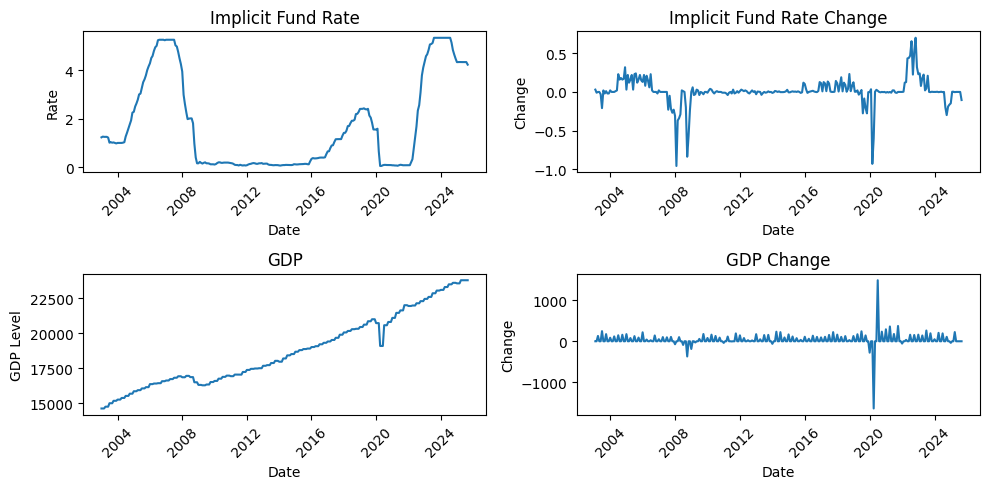

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# --- Top-left: Implicit Fund Rate ---
axes[0, 0].plot(df_features["Date"], df_features["implicite_fund_rate"])
axes[0, 0].set_title("Implicit Fund Rate")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Rate")
axes[0, 0].tick_params(axis='x', rotation=45)

# --- Top-right: Implicit Fund Rate Change ---
axes[0, 1].plot(df_features["Date"], df_features["implicite_fund_rate_change"])
axes[0, 1].set_title("Implicit Fund Rate Change")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Change")
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Bottom-left: GDP ---
axes[1, 0].plot(df_features["Date"], df_features["GDP"])
axes[1, 0].set_title("GDP")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("GDP Level")
axes[1, 0].tick_params(axis='x', rotation=45)

# --- Bottom-right: GDP Change ---
axes[1, 1].plot(df_features["Date"], df_features["GDP_change"])
axes[1, 1].set_title("GDP Change")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Change")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We see that distribution of ones and zeros is quite balanced, so we can simplify a lot our analysis by looking only at accuracy score to determine best model 

In [5]:
df_final=df_features.dropna()
print("balanced dataset for accuracy : ",df_final['target'].value_counts())

balanced dataset for accuracy :  target
0    146
1    120
Name: count, dtype: int64


# Description of modelisation part



Now, we will create a special class that allows us to run multiples classifier experiments (mlflow) with hyperparameter optimisation (optuna), for the sake of simplicity and non-overfitting, we look at just two sets of models : Logisitc Regression and Random Forests, which will be both ran with different sets of hyperparameters, features to select the best experiment

Also, it will be naive to think that all created features will be usefull, so even after penalizations such as L1 (which selects variables), we will pre-select relevant variables with permutation method which measures how much model performance drops when a single feature is randomly shuffled. If shuffling a variable severely harms accuracy, the model truly depends on it; if accuracy barely changes, the variable is not informative. This method gives a more realistic picture of each feature’s contribution,so we will filter out all variables that result in less then 1%(also a hyperparameter) drop in accuracy.

### First models

For the initial model selection phase, we employed a straightforward train-test split approach, using 80% of the chronologically ordered data for training and reserving the final 20% for testing. 

The primary benefit of this approach was the ability to rapidly iterate through numerous experimental configurations without the computational burden of implementing full rolling window validations for each candidate model. This allowed for broader exploration of the model space, testing various algorithms, feature combinations, and hyperparameter settings that would have been prohibitively expensive to evaluate using more intensive validation schemes.

### Backtesting

After identifying the most promising model configuration through the initial screening process, we transitioned to a more rigorous validation methodology. The champion model was subjected to a proper rolling window (walk-forward) validation approach, which is considered the gold standard for time series prediction tasks.

This rolling window validation simulates the real-world application of the model more faithfully. It works by training on an initial segment of data (for example, the first 60% of observations), making a prediction for the next time step.

In [7]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [optuna]2m1/2 [optuna]
Note: you may need to restart the kernel to use updated packages.


Le code ci-dessous définit une classe d’entraînement automatisé pour modèles de classification (Logistic Regression et Random Forest), intégrant la recherche d’hyperparamètres avec Optuna et le suivi d’expériences via MLflow. À partir d’un jeu de données et d’une liste de variables explicatives, la class `MlFlowModel` réalise un split temporel 80/20, standardise les variables si nécessaire, optimise les hyperparamètres (C, l1_ratio, profondeur, etc.), entraîne le modèle final et enregistre les performances (accuracy) ainsi que le modèle dans MLflow. 

Une fonction complémentaire, `var_selection_with_permutation`, permet de sélectionner les variables les plus informatives en mesurant, par permutation, l’impact de chaque feature sur la précision du modèle, et en filtrant celles dont l’importance est négligeable.


In [8]:
import pandas as pd
import mlflow
import optuna
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


def check_params(allowed,kwargs):

    """ 
    validator function to test validity of arguments in kwargs
    """


    for key,val in kwargs.items():

                if key not in allowed:
                    raise ValueError(f"{key} unrecongized, use : {allowed.keys()}")
                if val not in allowed[key]:
                    raise ValueError(f"{val} unrecongized, for {key} use : {allowed[key]}")

class MlFlowModel:

    """
    class that allows to automate model building:

        exper_name : str -> unique name of experiment being used in mlflow and optuna
        kwargs : dict -> hyperparameters depending on models (penalties etc )
        model_instance : class -> class instance of owr model

    Be Aware that we support only Logistic regression and Random Forests here



    """

    def __init__(self,exper_name,model_instance,**kwargs):

        """
        supports two models: logistic regression and random forest only 

        """
        self.model_instance=model_instance
        self.exper_name=exper_name
        self.kwargs=kwargs
        self.n_trials=10

        if isinstance(self.model_instance,type):
            raise ValueError(f"dont forget parantheses in your model_instance")
        

        if self.model_instance.__class__ is not   LogisticRegression and  self.model_instance.__class__ is not RandomForestClassifier:
            raise ValueError('sorry, we can use logistic regression and random forest only for the moment ')


        if self.model_instance.__class__ is  LogisticRegression:
            allowed={
                "penalty" : ["l1", "l2", "elasticnet", None],
                "solver" : "saga"
            }

            if "penalty" not in kwargs.keys() or "solver" not in kwargs.keys():
                raise ValueError("need to specify both penalty and solver for logistic regression ")

        if self.model_instance.__class__ is  RandomForestClassifier:
            allowed={
                "max_features" : ["sqrt", "log2", None],
                "criterion" : ["gini", "entropy", "log_loss"]
            }
            if "max_features" not in kwargs.keys() or "criterion" not in kwargs.keys():
                raise ValueError("need to specify both max_features and criterion for randm forest ")

        
        check_params(allowed,self.kwargs)

    
    def objective(self,trial):

                """
                objective function of loss to minimize in our models using optuna package

                """
                

                if self.model_instance.__class__ is  LogisticRegression:

                    if "elasticnet" == self.kwargs["penalty"]:
                        # Define hyperparameter search space
                        params_candidate_space={
                            "l1_ratio": trial.suggest_float("l1_ratio", 0.1, 0.9),
                            "C":  trial.suggest_float("C", 0.1, 10),
                        }
                    elif "l1" == self.kwargs["penalty"] or "l2" == self.kwargs["penalty"]:
                        # Define hyperparameter search space
                        params_candidate_space={
                            "C":  trial.suggest_float("C", 0.1, 10),
                        }
                    
                if self.model_instance.__class__ is  RandomForestClassifier:

                    params_candidate_space={
                            'max_depth': trial.suggest_int("max_depth", 10, 50),
                            "min_samples_split":  trial.suggest_int("min_samples_split", 2, 10),
                            "min_samples_leaf":  trial.suggest_int("min_samples_leaf", 1, 4),
                 
                        }

                

                model = self.model_instance.__class__(
                    **params_candidate_space, 
                    **self.fixed_params,
                    **self.kwargs  
                )
            

                model.fit(self.X_train, self.y_train)


                #log_loss is sklearn is negative loglikelihood so we minimise it!!
                #in randomforest if we use gini, then we need to modify this line, but we do simple:
                score = log_loss(self.y_train, model.predict_proba(self.X_train))

                return score



    def run_optuna_study(self):

        """
        access optuna experiments
        """

        storage = f"sqlite:///optruns/optuna_{self.exper_name}.db"
        study = optuna.create_study(
                            direction="minimize", 
                            study_name=f"{self.exper_name}",
                            storage=storage,
                            load_if_exists=True
        )  # 'minimize' for loss functions
        study.optimize(self.objective, n_trials=self.n_trials)
        study_best_params=study.best_params
        return study_best_params

    def train(self,merged_df_,feature_columns):

        """ 
        main function of model training that brings together each steps

        """
        
        with mlflow.start_run(run_name=f"{self.exper_name}_FedFunds"):
        
                mlflow.log_param("model_type", self.model_instance.__class__.__name__)
                mlflow.log_param("variables", feature_columns)
                mlflow.log_param("scaler", "StandardScaler")
                mlflow.log_param("train_test_split", "80/20 time series")
                mlflow.log_param("kwargs",self.kwargs)
                
                #do easy splits and transforms:
                X = merged_df_[feature_columns]
                y = merged_df_['target']
                split_idx = int(len(merged_df_) * 0.8)
                self.X_train, self.X_test = X.iloc[:split_idx], X.iloc[split_idx:]
                self.y_train, self.y_test = y.iloc[:split_idx], y.iloc[split_idx:]
                #always standartise variables for logit 
                if self.model_instance.__class__ is  LogisticRegression:
                    scaler = StandardScaler()
                    self.X_train = scaler.fit_transform(self.X_train)
                    self.X_test = scaler.transform(self.X_test)

                # Model penalisations

                if self.model_instance.__class__ is  LogisticRegression:
                    print("normalising data")
                    self.fixed_params={
                        
                        "class_weight" : 'balanced',  
                        "random_state" : 42,
                    }
                

                    if self.kwargs["penalty"] is not None:
                        #in this case need to search space for best hyperparameter
                        study_best_params=self.run_optuna_study()
                        print("Best Hyperparameters:",study_best_params)
                    else:
                        study_best_params={}

                if self.model_instance.__class__ is  RandomForestClassifier:
                    self.fixed_params={
                        "n_estimators" : 150,
                        "class_weight" : 'balanced',  
                        "random_state" : 42,
                       
                    }
                    study_best_params=self.run_optuna_study()
                    print("Best Hyperparameters:",study_best_params)
                    

                        
                model = self.model_instance.__class__(
                     **self.fixed_params,
                     **study_best_params,
                     **self.kwargs                
                )
                print("-----------")
                

               
                model.fit(self.X_train, self.y_train)
                # Predictions
                y_pred = model.predict(self.X_test)
                
                acc = accuracy_score(self.y_test, y_pred)
                mlflow.log_metric("accuracy", acc)
                mlflow.sklearn.log_model(model, name="model")

                print(f"Run logged to MLflow: accuracy={acc:.4f}")


def var_selection_with_permutation(model,X,y,threshold_below_which_to_drop=0.01):

    '''
    simple function to filter out variables non informative, 
    non informative variables are those,who after permutation decrease a bit performance of the model
    supports any classification model, models implying gradient descent (parametric models) require dataset to be normalised 
    models such as random forests or other non gradient tree models do not require variable standartisation 
    '''
    
    split_idx = int(len(X) * 0.8)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    if model.__class__.__name__ in ["LogisticRegression",]:
        
        scaler = StandardScaler().set_output(transform="pandas")
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)



    model.fit(X_train, y_train)
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42,scoring="accuracy")

    perm_importances = pd.DataFrame({
        'feature': X_test.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    })
    
    return perm_importances[perm_importances["importance_mean"]>threshold_below_which_to_drop]["feature"].tolist()

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


runs model just on spreads (simplest model) to see the results

In [9]:
model = LogisticRegression(random_state=42, class_weight='balanced')
feature_columns =  [f'spread_change_lag_{i}' for i in range(1, n_lags + 1)] 
X = df_final[feature_columns]
y = df_final['target']
feature_columns_after_permutation_test=var_selection_with_permutation(model,X,y)
print(
{
    "nb variables before permutation selection " : len(feature_columns),
    "nb variables after permutation selection " : len(feature_columns_after_permutation_test)

}
)
model=MlFlowModel("lrsimplest",LogisticRegression(),penalty=None,solver="saga")
model.train(df_final,feature_columns)

{'nb variables before permutation selection ': 6, 'nb variables after permutation selection ': 1}


/opt/python/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


normalising data
-----------


2025/11/15 15:48:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.4815


the model is even worse then random guessing, so we will continue ..., for example now we will take all lagged variables (in difference)

In [10]:
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]


model=MlFlowModel("lr-all-vars",LogisticRegression(),penalty=None,solver="saga")
model.train(df_final,feature_columns)

normalising data
-----------


2025/11/15 15:49:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.6852


better,let's try to use penalties

In [11]:
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]


model=MlFlowModel("lr-all-vars",LogisticRegression(),penalty="elasticnet",solver="saga")
model.train(df_final,feature_columns)

normalising data


[I 2025-11-15 15:49:41,163] A new study created in RDB with name: lr-all-vars
[I 2025-11-15 15:49:41,241] Trial 0 finished with value: 0.46617867719053574 and parameters: {'l1_ratio': 0.8724733523335282, 'C': 8.391761356714966}. Best is trial 0 with value: 0.46617867719053574.
[I 2025-11-15 15:49:41,291] Trial 1 finished with value: 0.46898123788305934 and parameters: {'l1_ratio': 0.692831425178645, 'C': 2.907302765725208}. Best is trial 0 with value: 0.46617867719053574.
[I 2025-11-15 15:49:41,340] Trial 2 finished with value: 0.46662644287120203 and parameters: {'l1_ratio': 0.4724201892358635, 'C': 4.791900869824793}. Best is trial 0 with value: 0.46617867719053574.
[I 2025-11-15 15:49:41,390] Trial 3 finished with value: 0.4657215483704304 and parameters: {'l1_ratio': 0.638385687424998, 'C': 9.471957254184352}. Best is trial 3 with value: 0.4657215483704304.
[I 2025-11-15 15:49:41,449] Trial 4 finished with value: 0.46615165548916915 and parameters: {'l1_ratio': 0.5553909979800165, 

Best Hyperparameters: {'l1_ratio': 0.638385687424998, 'C': 9.471957254184352}
-----------


2025/11/15 15:49:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.6852


let's filter 54 variables-> we get only 9 informative ones (as model penalisation)

In [12]:
model = LogisticRegression(random_state=42, class_weight='balanced')
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]
X = df_final[feature_columns]
y = df_final['target']
feature_columns_after_permutation_test=var_selection_with_permutation(model,X,y)
print(
{
    "nb variables before permutation selection " : len(feature_columns),
    "nb variables after permutation selection " : len(feature_columns_after_permutation_test)

}
)
model=MlFlowModel("lr-per-vars0.01-elnet",LogisticRegression(),penalty="elasticnet",solver="saga")
model.train(df_final,feature_columns_after_permutation_test)

[I 2025-11-15 15:50:14,207] A new study created in RDB with name: lr-per-vars0.01-elnet
[I 2025-11-15 15:50:14,259] Trial 0 finished with value: 0.5362693074334574 and parameters: {'l1_ratio': 0.786319089867239, 'C': 9.20900940229256}. Best is trial 0 with value: 0.5362693074334574.


{'nb variables before permutation selection ': 54, 'nb variables after permutation selection ': 9}
normalising data


[I 2025-11-15 15:50:14,296] Trial 1 finished with value: 0.5363838997267638 and parameters: {'l1_ratio': 0.7892238292746151, 'C': 4.404688265195653}. Best is trial 0 with value: 0.5362693074334574.
[I 2025-11-15 15:50:14,329] Trial 2 finished with value: 0.5364007429098018 and parameters: {'l1_ratio': 0.34482632377633937, 'C': 4.963088620995323}. Best is trial 0 with value: 0.5362693074334574.
[I 2025-11-15 15:50:14,366] Trial 3 finished with value: 0.5363439644029989 and parameters: {'l1_ratio': 0.8679746258240897, 'C': 5.104564517351857}. Best is trial 0 with value: 0.5362693074334574.
[I 2025-11-15 15:50:14,399] Trial 4 finished with value: 0.5365393601672344 and parameters: {'l1_ratio': 0.1666581419628165, 'C': 3.5380765919978}. Best is trial 0 with value: 0.5362693074334574.
[I 2025-11-15 15:50:14,437] Trial 5 finished with value: 0.5407883845305301 and parameters: {'l1_ratio': 0.8789756658378449, 'C': 0.548591827655413}. Best is trial 0 with value: 0.5362693074334574.
[I 2025-11-

Best Hyperparameters: {'l1_ratio': 0.786319089867239, 'C': 9.20900940229256}
-----------


2025/11/15 15:50:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.6667


try random forests

In [ ]:
model=MlFlowModel("rf-per-vars0.02-sqrt-logloss",RandomForestClassifier(),max_features="sqrt",criterion="log_loss")
model.train(df_final,feature_columns_after_permutation_test)

[I 2025-11-15 15:51:40,386] Using an existing study with name 'rf-per-vars0.02-sqrt-logloss' instead of creating a new one.
[I 2025-11-15 15:51:40,677] Trial 10 finished with value: 0.21327731173956077 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.1760649456120853.


[I 2025-11-15 15:51:40,931] Trial 11 finished with value: 0.21666830694424136 and parameters: {'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.1760649456120853.
[I 2025-11-15 15:51:41,187] Trial 12 finished with value: 0.1490029395315216 and parameters: {'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.1490029395315216.
[I 2025-11-15 15:51:41,456] Trial 13 finished with value: 0.1490029395315216 and parameters: {'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.1490029395315216.
[I 2025-11-15 15:51:41,727] Trial 14 finished with value: 0.1490029395315216 and parameters: {'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.1490029395315216.
[I 2025-11-15 15:51:41,986] Trial 15 finished with value: 0.3172640467265919 and parameters: {'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is t

Best Hyperparameters: {'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1}
-----------


2025/11/15 15:51:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.8889


results significantly increased, indicating non linear relationship in models

In [15]:
model = LogisticRegression( random_state=42,class_weight='balanced')
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]
X = df_final[feature_columns]
y = df_final['target']
feature_columns_after_permutation_test=var_selection_with_permutation(model,X,y,0.01)
print(
{
    "nb variables before permutation selection " : len(feature_columns),
    "nb variables after permutation selection " : len(feature_columns_after_permutation_test)

}
)
model=MlFlowModel("rf-per-vars0.01-sqrt-gini",RandomForestClassifier(),max_features="sqrt",criterion="gini")
model.train(df_final,feature_columns_after_permutation_test)

[I 2025-11-15 15:52:32,850] A new study created in RDB with name: rf-per-vars0.01-sqrt-gini


{'nb variables before permutation selection ': 54, 'nb variables after permutation selection ': 9}


[I 2025-11-15 15:52:33,163] Trial 0 finished with value: 0.19676277958620023 and parameters: {'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.19676277958620023.
[I 2025-11-15 15:52:33,407] Trial 1 finished with value: 0.2541865009841746 and parameters: {'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.19676277958620023.
[I 2025-11-15 15:52:33,658] Trial 2 finished with value: 0.16025346379215932 and parameters: {'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.16025346379215932.
[I 2025-11-15 15:52:33,922] Trial 3 finished with value: 0.17795464615809028 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.16025346379215932.
[I 2025-11-15 15:52:34,170] Trial 4 finished with value: 0.28655097496196247 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is tr

Best Hyperparameters: {'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1}
-----------


2025/11/15 15:52:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.9074


we visualise all past experiments to get the best model with corresponding hyperparameters and features 

In [16]:

import mlflow 
experiments = mlflow.search_experiments()
runs=mlflow.search_runs(experiment_ids=[exp.experiment_id for exp in experiments])
best=runs.sort_values("metrics.accuracy",ascending=False)[["status","run_id","metrics.accuracy","params.model_type","params.variables","params.kwargs","tags.mlflow.runName"]].reset_index(drop=True)
champion_model_id=best["run_id"][0]
champion_model_variables=ast.literal_eval(best["params.variables"][0])
champion_model_kwargs=ast.literal_eval(best["params.kwargs"][0])
champion_model_name=best["tags.mlflow.runName"][0]
champion_model_name = champion_model_name.replace('FedFunds', '')
champion_model_name= champion_model_name.replace('_', '')
best.head()

,status,run_id,metrics.accuracy,params.model_type,params.variables,params.kwargs,tags.mlflow.runName
0,FINISHED,b5ccf0bde2834f599633dff5f95d5d5e,0.907407,RandomForestClassifier,"['implicite_fund_rate_change_lag_1', 'implicit...","{'max_features': 'sqrt', 'criterion': 'gini'}",rf-per-vars0.01-sqrt-gini_FedFunds
1,FINISHED,6a98191bddc340a785046203ded30c80,0.888889,RandomForestClassifier,"['implicite_fund_rate_change_lag_1', 'implicit...","{'max_features': 'sqrt', 'criterion': 'log_loss'}",rf-per-vars0.02-sqrt-logloss_FedFunds
2,FINISHED,a2ec6de24e1d42d0a817a83074fd319b,0.888889,RandomForestClassifier,"['implicite_fund_rate_change_lag_1', 'implicit...","{'max_features': 'sqrt', 'criterion': 'log_loss'}",rf-per-vars0.02-sqrt-logloss_FedFunds
3,FINISHED,89a010a67a074826b84d743341087812,0.685185,LogisticRegression,"['spread_change_lag_1', 'spread_change_lag_2',...","{'penalty': 'elasticnet', 'solver': 'saga'}",lr-all-vars_FedFunds
4,FINISHED,2367cbd90de04e4abbc5baecca7839ec,0.685185,LogisticRegression,"['spread_change_lag_1', 'spread_change_lag_2',...","{'penalty': None, 'solver': 'saga'}",lr-all-vars_FedFunds


Access best hyperparameters of champion model 

In [17]:
storage=f"sqlite:///optruns/optuna_{champion_model_name}.db"
study = optuna.load_study(
    study_name=champion_model_name,
    storage=storage 
)

print("Best params:", study.best_params)

Best params: {'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1}


Load this model and use it for validation and backtesting

In [18]:
champion_model=mlflow.pyfunc.load_model(f"runs:/{champion_model_id}/model")
champion_model_variables

['implicite_fund_rate_change_lag_1',
 'implicite_fund_rate_change_lag_2',
 'implicite_fund_rate_change_lag_3',
 'PCEPI_change_lag_1',
 'PCEPI_change_lag_6',
 'GDP_change_lag_1',
 'GDP_change_lag_3',
 'INDPRO_change_lag_1',
 'INDPRO_change_lag_2']

Now, once we have the best model we can do model validation and visualisation of results, as well as do rolling model 

In [19]:
X = df_final[champion_model_variables]
y = df_final['target']
split_idx = int(len(df_final) * 0.8)
X_train,X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Predictions
y_pred = champion_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.9074074074074074

so if we use non temporal approach, then we get 90% accuracy

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    construct matrix of errors (confusion)
    cm - matrix of errors 
    classes - list of classes
    normalize - if True then normalised to 1
    title - title
    cmap - colors
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


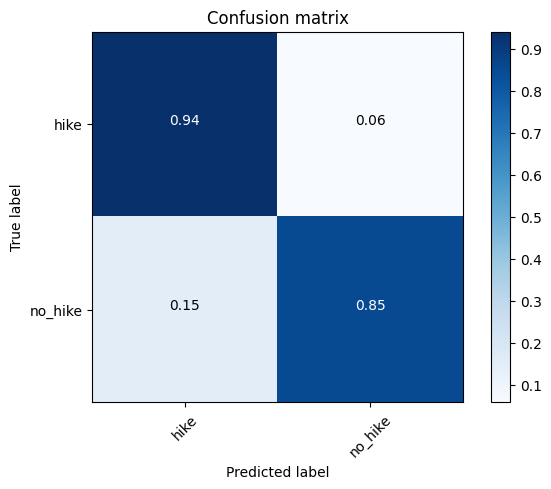

In [21]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,["hike","no_hike"],normalize=True)

Now, let's assume that we found the best model  like this also for the rolling windows approach to back test dynamically on each day prediction: 

In [22]:

X = df_final[champion_model_variables].values
y = df_final['target'].values

n = len(df_final)

#Starting point for first train window (for example we take 60%)
start_idx = int(n * 0.60)
predictions = []
actuals = []
accuracies=[]
for t in range(start_idx, n - 1):

    # Training set = from 0 to t
    X_train = X[:t]          
    y_train = y[:t]

    # Test point = next step (t+1)
    X_test = X[t].reshape(1, -1)
    y_test = y[t]

    # Train model
    model = RandomForestClassifier(
        n_estimators=150,
     
        random_state=42,
        **study.best_params,
        class_weight ='balanced'
    )
    model.fit(X_train, y_train)

    # Predict t+1
    pred = model.predict(X_test)[0]

    predictions.append(pred)
    
    actuals.append(y_test)
    accuracies.append(accuracy_score(actuals, predictions))

# Final rolling accuracy
rolling_accuracy = accuracy_score(actuals, predictions)
print("Rolling Forecast Accuracy:", rolling_accuracy)

Rolling Forecast Accuracy: 0.8207547169811321


we see that final rolling accuracy is of 80% which is good for rolling window approach 

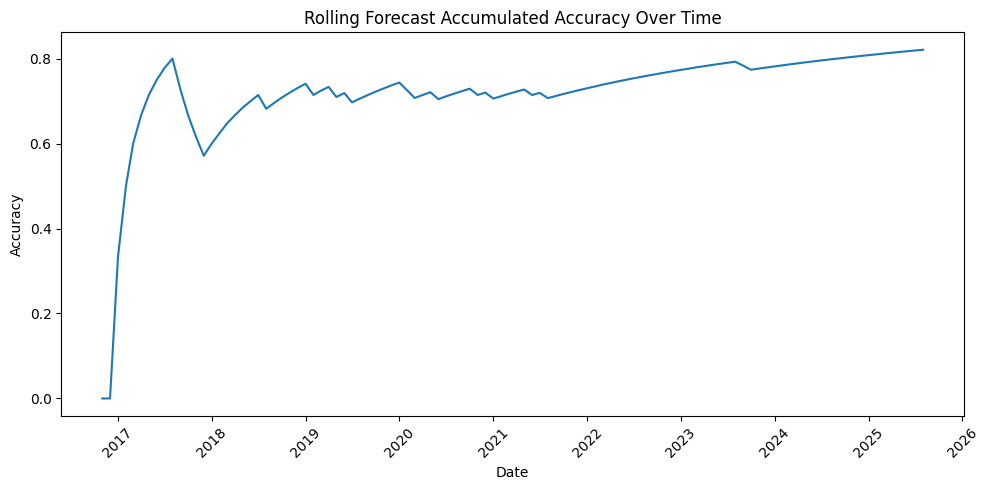

In [23]:
accuracy_dates = df_final['Date'][start_idx : n-1].reset_index(drop=True)
plt.figure(figsize=(10,5))
plt.plot(accuracy_dates, accuracies)
plt.title("Rolling Forecast Accumulated Accuracy Over Time")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#this graphic is not very interesting as it is like accumulated accuracy, but still we see fast convergence to 80% 

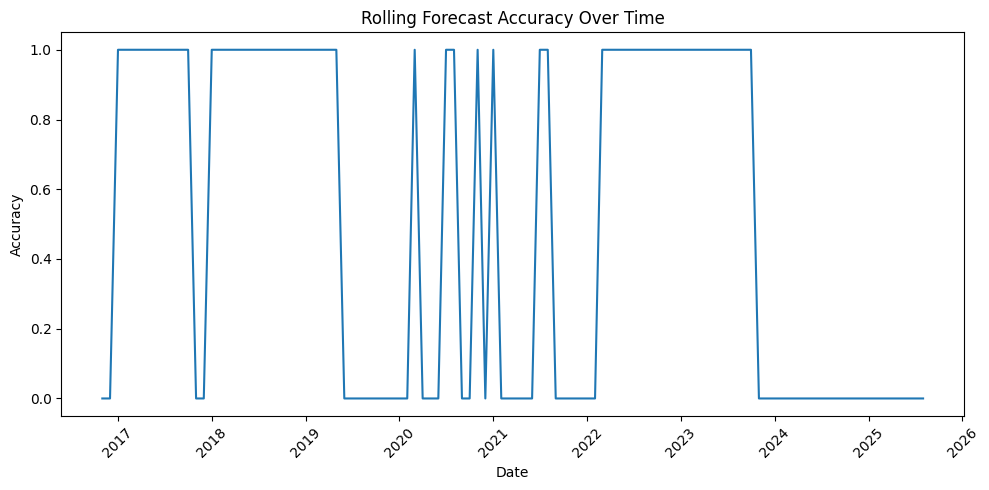

In [24]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_dates, predictions)
plt.title("Rolling Forecast Accuracy Over Time")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

accuracy for each day is measured 0 or 1 simply, we see that the model behaves very well for all months between 2022 and 2024(latest data when train period is from 2000), however, there were lot of instability between 2019 and 2021 which can be related also to covid-19.

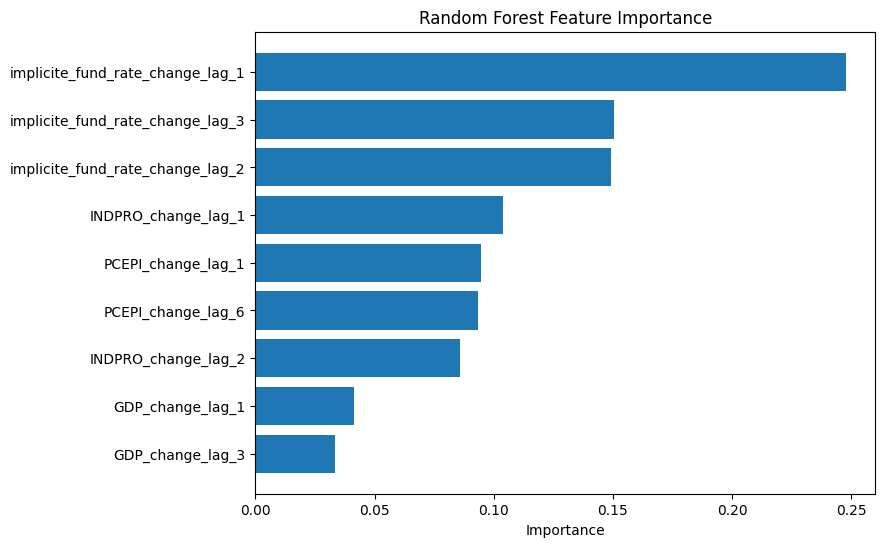

In [25]:
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    'feature': champion_model_variables,
    'importance': importances
}).sort_values('importance', ascending=False)


plt.figure(figsize=(8,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

Finally what is interesting is to understand what features are the most important for our classification , clearly the most important are implicit fund rate short term memory up to lag 3 , personal consumtion expenditures and industrial production index. These importances are calculated during training of random forests. for each decision tree at each split generated by certain variable we measure decrease in entropy , then we simply average these decreasings for every variable, the highest decreasings are highest importances.

## Conclusion

Ce notebook avait pour objectif d’évaluer dans quelle mesure les Fed Funds Futures, enrichis par des variables macroéconomiques mensuelles, permettent de modéliser la probabilité d’une hausse du taux des Fed Funds. Dans un premier temps, l’analyse descriptive et les régressions montrent que le taux implicite extrait des contrats futures réplique correctement le niveau du taux directeur effectif : l’écart entre les deux séries reste limité et la dynamique des hausses/baisse de taux est bien capturée. Cela confirme que les futures contiennent une information riche sur les anticipations de marché concernant la politique monétaire.

Sur cette base, le notebook bascule ensuite vers une approche de classification binaire « hike / no hike ». Une cible est construite à partir de la variation future du Fed Funds rate et un ensemble de variables explicatives est généré à partir du spread entre futures et taux effectif, de ses retards, ainsi que des principales séries macroéconomiques, transformées en variations mensuelles et décalées jusqu’à six mois. Des modèles de régression logistique pénalisée et de Random Forest sont estimés et sélectionnés via Optuna et MLflow, avec une étape de sélection de variables par permutation importance afin de ne conserver que les signaux les plus informatifs.

Les résultats suggèrent qu’en « coupe statique » (sans respecter strictement la structure temporelle des données), le pouvoir explicatif du modèle est élevé : les hausses de taux sont en grande partie correctement identifiées. En revanche, lorsque l’on passe à une véritable évaluation temporelle de type backtest (apprentissage sur le passé, test sur le futur en fenêtre roulante), la performance se réduit mais demeure significative, ce qui met en évidence la difficulté de prévoir en temps réel, en particulier autour des périodes de rupture de régime monétaire. L’analyse des importances de variables indique que certains lags du spread, ainsi que des chocs macroéconomiques liés à l’inflation, à l’activité réelle, au marché du travail et aux indicateurs de stress financier, jouent un rôle central dans la décision de hausse ou non de la Fed.

Au final, ce travail montre que les Fed Funds Futures, combinés à un petit nombre de signaux macroéconomiques, permettent de construire un modèle probabiliste cohérent des hausses de taux de la Fed. Néanmoins, la taille de l’échantillon, la fréquence mensuelle et les changements de régime limitent la robustesse des résultats et invitent à la prudence dans toute interprétation opérationnelle. Des prolongements naturels seraient d’affiner la gestion du déséquilibre de classes, d’explorer d’autres architectures (gradient boosting, modèles séquentiels) et d’intégrer explicitement le calendrier des réunions du FOMC.
